In [20]:
# import jaxlib
# from jax_unirep import get_reps
import pandas as pd
import os
import numpy as np

from collections import defaultdict
from UniRep.unirep_utils import get_UniReps

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn import model_selection
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

from Bio.SeqUtils import molecular_weight
from Bio.SeqUtils.IsoelectricPoint import IsoelectricPoint as IP

import matplotlib.pyplot as plt
# import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Functions

In [2]:
def data_to_unirep(df):
    """
    Generates a new data frame with the UniProt ID, UniRep 1900 vectors (x-values), and secretion state (y-values)
    
    Args:
        df (DataFrame): original data frame with sequence information and class information (specifying secretion)
        
    Returns:
        unirep_df (DataFrame): new unirep data frame with class information and unirep vectors
    """
    seq_key = 'Sequence'
    vec_prefix = 'Vec_{}'
    
    # Generating new data frame with unirep vectors
    vec_column_names = [vec_prefix.format(i) for i in range(1900)]        
    unirep_df = pd.DataFrame(columns = ['Class'] + vec_column_names)

    for i, row in df.iterrows():
        if int(i) % 1 == 0:
            print('row {}'.format(i), end='\r')
        sequence = row.loc[seq_key]
        unirep_df.loc[i, 'Class'] = row['Class']
        vec = get_UniReps(sequence)[0][0]
        unirep_df.loc[i, vec_column_names] = vec
    
    return unirep_df

In [3]:
def remove_ambiguous_aa(df):
    """
    Filters out protein sequences in data frame without ambiguous amino acids (X, B, and U)
    
    Args:
        df (DataFrame): data frame with amino acid sequences and input data
        
    Returns:
        df (DataFrame): filtered data frame without ambiguous amino acid sequences
    """
    seq_key = 'seq'
    ambiguous_aa = ['X', 'B', 'U']
    for aa in ambiguous_aa:
        df = df[~df[seq_key].str.contains(aa)]
    return df

In [4]:
def classifier_comparison(X, y, seed):
    """
    Iterates through sklearn supervised learning classification models.
    Performs k-fold cross-validation (k=10).
    Comparing each classifier based on model accuracy.
    Plots model accuracy on a boxplot.
    Taken from https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/
    
    Args:
        X (Array-like): All of the input parameters (including UniRep vectors) for the secretion analysis model
        y (Array-like): The ouput parameter, or secretion class, for the secretion analysis model
        
    Returns:
        
    """
    # Preparing models
    models = []
    models.append(('RidgeReg', RidgeClassifierCV(alphas=[1e-3, 1e-2, 1e-1, 1],normalize=True)))
    K_neighbors = int(np.sqrt(len(y_train)))
    models.append(('KNN', KNeighborsClassifier(K_neighbors, weights='uniform')))
    models.append(('NeuralNet', MLPClassifier(max_iter=200)))
    models.append(('RandomForest', RandomForestClassifier()))
    models.append(('RBF SVM', SVC(gamma=0.1, C=1)))
    
    # Evaluating each model using cross-validation
    results = []
    names = []
    scoring = 'accuracy'
    for name, model in models:
        kfold = model_selection.KFold(n_splits=5, random_state=seed, shuffle=True)
        cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
    # Plotting the classifier comparison
    fig = plt.figure()
    fig.suptitle('Sklearn Model Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()

In [5]:
# Selecting the final models to build
def ridge_regression_classifier(X_train, X_test, y_train, y_test):
    """
    Performs ridge regression classification on the given X and y values. Trains the model using X_train and y_train.
    
    Args:
        X_train (Array-like): input parameters (including UniRep vectors) for the training the secretion analysis model
        X_test (Array-like): input parameters (including UniRep vectors) for testing the secretion model
        y_train (Array-like): secretion class / output associated with the trained secretion data (X_train)
        y_test (Array-like): secretion class / output associated with the tested secretion data (X_test)
    
    Returns:
        model: ridge regression classification model
    """
    model = RidgeClassifierCV(alphas=[1e-3, 1e-2, 1e-1, 1],normalize=True)
    model.fit(X_train, y_train)
    return model


def knn_classifier(X_train, X_test, y_train, y_test):
    """
    Performs K-nearest neighbors classification on the given X and y values. Trains the model using X_train and y_train.
    
    Args:
        X_train (Array-like): input parameters (including UniRep vectors) for the training the secretion analysis model
        X_test (Array-like): input parameters (including UniRep vectors) for testing the secretion model
        y_train (Array-like): secretion class / output associated with the trained secretion data (X_train)
        y_test (Array-like): secretion class / output associated with the tested secretion data (X_test)
    
    Returns:
        model: K-nearest neighbors classification model
    """
    K_neighbors = int(np.sqrt(len(y_train))) # set number of neighbors to square root of number of inputs
    model = KNeighborsClassifier(K_neighbors, weights='uniform')
    model.fit(X_train, y_train)
    return model


def neural_net_classifier(X_train, X_test, y_train, y_test):
    """
    Performs MLP classification on the given X and y values. Trains the model using X_train and y_train.
    
    Args:
        X_train (Array-like): input parameters (including UniRep vectors) for the training the secretion analysis model
        X_test (Array-like): input parameters (including UniRep vectors) for testing the secretion model
        y_train (Array-like): secretion class / output associated with the trained secretion data (X_train)
        y_test (Array-like): secretion class / output associated with the tested secretion data (X_test)
    
    Returns:
        model: MLP classification model (sklearn neural network)
    """
    model = MLPClassifier(max_iter=200)
    model.fit(X_train, y_train)
    return model


def random_forest_classifier(X_train, X_test, y_train, y_test):
    """
    Uses random forests to classify based on the given X and y values.
    
    Args:
        X_train (Array-like): input parameters (including UniRep vectors) for the training the secretion analysis model
        X_test (Array-like): input parameters (including UniRep vectors) for testing the secretion model
        y_train (Array-like): secretion class / output associated with the trained secretion data (X_train)
        y_test (Array-like): secretion class / output associated with the tested secretion data (X_test)
    
    Returns:
        model: random forest classification model
    """
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    return model


def rbf_svm_classifier(X_train, X_test, y_train, y_test):
    """
    Uses rbf support vector machines to classify based on the given X and y values.
    
    Args:
        X_train (Array-like): input parameters (including UniRep vectors) for the training the secretion analysis model
        X_test (Array-like): input parameters (including UniRep vectors) for testing the secretion model
        y_train (Array-like): secretion class / output associated with the trained secretion data (X_train)
        y_test (Array-like): secretion class / output associated with the tested secretion data (X_test)
    
    Returns:
        model: rbf svm classficiation model
    """
# Run the following in order to figure out the best C and gamma values!
#     C_range = np.logspace(-2, 10, 13)
#     gamma_range = np.logspace(-3, 3, 7)
#     for i in range(len(C_range)):
#     for j in range(len(gamma_range)):
#         model=SVC(gamma=gamma_range[j], C=C_range[i]).fit(X_train, y_train)
#         print("Gamma:", gamma_range[j], "C:", C_range[i], "Score:", model.score(X_test, y_test))
    model = SVC(gamma=0.1, C=1)
    model.fit(X_train, y_train)
    return model

In [6]:
# These parameters are for the `use_additional_features` function
# They are from the Hessa et al. paper cited in the function
params = pd.read_csv('Params.csv', header=None)
lst = params[0].values
params.set_index(lst, inplace=True)
del params[0]
params_dict = defaultdict(list)
for i, row in params.iterrows():
    for position in range(1, len(row) + 1):
        params_dict[i].append(float(row.loc[position]))

In [7]:
def use_additional_features(df):
    """
    Uses additional features to help improve the model. 
    Additional features include:
        theoretical isoelectric point, amino acid length, amino acid weight,
        free energy of transmembrane insertion
        
    Check https://biopython.org/docs/1.75/api/Bio.SeqUtils.html
    Free energy of transmembrane insertion values from
        Hessa, T., Meindl-Beinker, N., Bernsel, A. et al. Molecular code for transmembrane-helix recognition 
        by the Sec61 translocon. Nature 450, 1026–1030 (2007). https://doi.org/10.1038/nature06387
    
    Args:
        df (DataFrame): data frame including all of the inputs (sequence, unirep vectors, and secretion class)
    
    Returns:
        df_with_add_features (DataFrame): modified data frame with additional features listed above
    """
    # First append new columns for the theoretical isoelectric point,
    # amino acid length, and molecular weight
    seq_key = 'seq'
    df_with_add_features = df.copy(deep=True)
    df_with_add_features['PI'] = 0
    df_with_add_features['Molecular_Weight'] = 0
    df_with_add_features['Sequence_Length'] = 0
    for i, row in df_with_add_features.iterrows():
        seq = row.loc[seq_key]
        seq_obj = IP(seq)
        df_with_add_features.loc[i, 'PI'] = seq_obj.pi()
        df_with_add_features.loc[i, 'Molecular_Weight'] = round(molecular_weight(seq, seq_type='protein'))
        df_with_add_features.loc[i, 'Sequence_Length'] = len(seq)

    # Next, add the free energy of membrane insertion values
    df_with_add_features['dG'] = 0
    for i, row in df.iterrows():
        if int(i) % 10 == 0:
            print('row {} of {}'.format(i, len(df.index)), end="\r") # Set a progress check
        seq = row.loc[seq_key]
        # Skips sequence if the entire sequence length is less than 19
        if len(seq) < 19:
            continue
        dg_values = []
        # Scans sequence for every 19-residue frame
        for j in range(len(seq)-18):
            running_total = 0
            new_segment = seq[j:j+19]
            for k, aa in enumerate(new_segment):
                if aa == 'U':
                    pass
                else:
                    running_total += params_dict[aa][k]
            dg_values.append(running_total) 
        # Finds the minimum dG value
        df_with_add_features.loc[i, 'dG'] = min(dg_values)
        
    # Finally, return the updated data frame with additional features
    return df_with_add_features

In [8]:
def secretion_optimization_unirep(seq, pos, model):
    """
    Based on the given model, this function mutates the input sequence at the position provided
    Uses only the unirep vectors as input values
    
    Args:
        seq (String): initial amino acid sequence provided with single-letter format
        pos (int): position where the mutations can occur in the given sequence
        model:
    
    Returns:
        seq (String): final, mutated amino acid sequence with improved secretion score
    """
    # First, obtain the unirep representation of given sequence
    unirep_values = get_UniReps(seq)[0]
    unirep_values = unirep_values.reshape(1, -1)
    
    # Next, predict the initial secretion score
    print("The initial sequence is:", seq)
    initial_class = model.predict(unirep_values)
    print("The initial class is:", initial_class)
    classes = list(model.classes_)
    if type(model) is RidgeClassifierCV:
        decision_function_values = model.decision_function(unirep_values)[0]
        probs = np.exp(decision_function_values) / np.sum(np.exp(decision_function_values))
        initial_score = probs[classes.index('secreted')]
    else:
        prediction_probability = list(model.predict_proba(unirep_values)[0]) # Grabbing the probability of each class
        initial_score = prediction_probability[classes.index('secreted')] # Grabbing the probability of being secreted class
    print("The initial probability of being the secreted class is:", initial_score)
    
    # Set up list of amino acids
    amino_acids = ['G', 'A', 'L', 'M', 'F', 'W', 'K', 'Q', 'E', 'S', 'P', 'V', 'I', 'C', 'Y', 'H', 'R', 'N', 'D', 'T']
    
    # Set up point mutations
    mutated_scores_for_all_AA = []
    for i in range(len(amino_acids)):
        seq_list = list(seq)
        seq_list[pos] = amino_acids[i]
        new_seq = "".join(seq_list) # Creating the point-mutated sequence
        mutated_unirep_values = get_UniReps(new_seq)[0] # Grabbing the input parameters (unirep vectors)
        mutated_unirep_values = mutated_unirep_values.reshape(1, -1)
        mutated_class = model.predict(mutated_unirep_values) # The class of the mutated sequence
        classes = list(model.classes_)
        if type(model) is RidgeClassifierCV:
            decision_function_values = model.decision_function(mutated_unirep_values)[0]
            probs = np.exp(decision_function_values) / np.sum(np.exp(decision_function_values))
            mutated_score = probs[classes.index('secreted')]
        else:
            prediction_probability = list(model.predict_proba(mutated_unirep_values)[0]) # Grabbing the probability of each class
            mutated_score = prediction_probability[classes.index('secreted')] # Grabbing the probability of being secreted class
        mutated_scores_for_all_AA.append(mutated_score)
        if mutated_score > initial_score:
            seq = new_seq
            initial_score = mutated_score
            initial_class = mutated_class
    print("The improved, mutated sequence is:", seq)
    print("The mutated class is:", initial_class)
    print("The mutated probability of being the secreted class is:", initial_score)
    
    plt.plot(amino_acids, mutated_scores_for_all_AA)
    plt.xlabel('Amino Acid Point Mutation')
    plt.ylabel('Probability of Class: Secreted (%)')
    plt.show()
            
    return seq

# Importing UniProt Data

In [9]:
# Importing the true data sets with unirep features
human_unirep_noSP = pd.read_pickle('UniRep Datasets/combined_human_UniRep_dataset_noSP.pkl')
human_unirep_withSP = pd.read_pickle('UniRep Datasets/combined_human_UniRep_dataset_withSP.pkl')

yeast_unirep_noSP = pd.read_pickle('UniRep Datasets/combined_yeast_UniRep_dataset.pkl')
yeast_unirep_withSP = pd.read_pickle('UniRep Datasets/combined_yeast_UniRep_dataset_noSP.pkl')

ecoli_unirep_noSP = pd.read_pickle('UniRep Datasets/combined_escherichia_UniRep_dataset_noSP.pkl')

# Next, eliminate ambiguous amino acids
human_unirep_noSP = remove_ambiguous_aa(human_unirep_noSP)
human_unirep_withSP = remove_ambiguous_aa(human_unirep_withSP)

yeast_unirep_noSP = remove_ambiguous_aa(yeast_unirep_noSP)
yeast_unirep_withSP = remove_ambiguous_aa(yeast_unirep_withSP)

ecoli_unirep_noSP = remove_ambiguous_aa(ecoli_unirep_noSP)

# Code and Analysis for Human UniRep Datasets

First, run the sklearn model comparison function for the human data set with and without the signal peptide.

In [10]:
# Running the model comparison on human data set WITH signal peptides
X = np.stack(human_unirep_withSP["UniRep"].to_numpy())
y = np.array(human_unirep_withSP['location'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

RidgeReg: 0.973511 (0.005004)
KNN: 0.906011 (0.004733)
NeuralNet: 0.978986 (0.001069)
RandomForest: 0.973510 (0.004383)
RBF SVM: 0.970072 (0.002754)


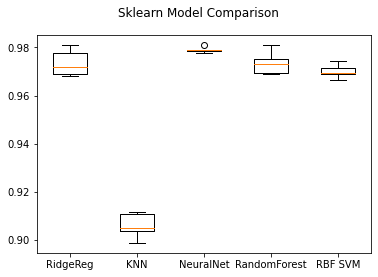

In [11]:
classifier_comparison(X, y, 42)

In [12]:
# Running the model comparison on human data set WITHOUT signal peptides
X2 = np.stack(human_unirep_noSP["UniRep"].to_numpy())
y2 = np.array(human_unirep_noSP['location'])
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

RidgeReg: 0.914067 (0.004250)
KNN: 0.856540 (0.006883)
NeuralNet: 0.929093 (0.003177)
RandomForest: 0.926726 (0.003223)
RBF SVM: 0.919316 (0.005318)


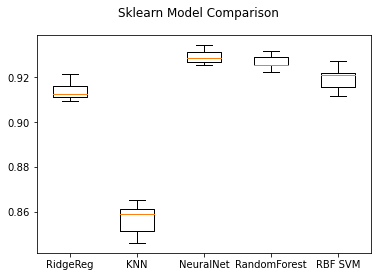

In [13]:
classifier_comparison(X2, y2, 42)

Next, test the secretion optimizer mutation function.

The initial sequence is: ACCAMGGSGCGSGSGSACCAMGGS
The initial class is: ['cytoplasm']
The initial probability of being the secreted class is: 0.1882073742656035
The improved, mutated sequence is: ACCAMGGSGCQSGSGSACCAMGGS
The mutated class is: ['cytoplasm']
The mutated probability of being the secreted class is: 0.2453633063786568


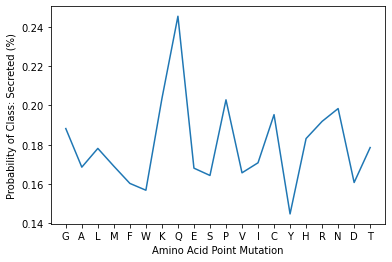

'ACCAMGGSGCQSGSGSACCAMGGS'

In [21]:
# Using an example model to test out the secretion_optimization_unirep function
# Using human data WITHOUT signal peptides
model = ridge_regression_classifier(X2_train, X2_test, y2_train, y2_test) # Define function used
seq = 'ACCAMGGSGCGSGSGSACCAMGGS' # Provide initial sequence
position = 10 # Provide position for point mutations

secretion_optimization_unirep(seq, position, model)

Now, move on to analysis including additional features.

In [15]:
# Appending additional features to the human data
human_unirep_withSP_add = use_additional_features(human_unirep_withSP)
human_unirep_noSP_add = use_additional_features(human_unirep_noSP)
human_unirep_noSP_add.head()

,ID,name,organism,location,seq,seq_len,UniRep,PI,Molecular_Weight,Sequence_Length,dG
0,P03540,GLYC_PIARV,piarv,membrane,MGQIVTLIQSIPEVLQEVFNVALIIVSVLCIVKGFVNLMRCGLFQL...,503,"[0.004571974277496338, -0.03903784230351448, 0...",8.391672,57278,503,-0.18
1,Q99928,GBRG3_HUMAN,human,membrane,MAPKLLLLLCLFSGLHARSRKVEEDEYEDSSSNQKWVLAPKSQDTD...,467,"[0.010569660924375057, -0.04060269147157669, 0...",7.462982,54288,467,-1.27
2,Q77NP2,GM_VZVO,vzvo,membrane,MGTQKKGPRSEKVSPYDTTTPEVEALDHQMDTLNWRIWIIQVMMFT...,435,"[0.0069412547163665295, -0.012156936340034008,...",9.198301,48671,435,-2.11
3,Q04630,GM_HHV6U,hhv6u,membrane,MASSRVDTINLRIWLVSIICAALSFINVTVYLIAINFPNLGFPCAY...,344,"[0.0053085871040821075, -0.009203316643834114,...",8.653930,38992,344,-3.96
4,Q68669,GL_HCMV3,hcmv3,membrane,MCRRPDCGFSFSPGPVVLLWCCLLLPIVSSVAVSVAPTAAEKVPAE...,278,"[0.004815185442566872, -0.03920815885066986, 0...",6.879075,30813,278,-0.23


In [16]:
# Perform a rough comparison with initial models
# Analysis below WITHOUT signal peptides
X3 = np.stack(human_unirep_noSP_add["UniRep"].to_numpy())
y3 = np.array(human_unirep_noSP_add['location'])
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42)

ridge1 = ridge_regression_classifier(X2_train, X2_test, y2_train, y2_test)
ridge2 = ridge_regression_classifier(X3_train, X3_test, y3_train, y3_test)

print("Initial:", ridge1.score(X2_test, y2_test), "With additional features:", ridge2.score(X3_test, y3_test))

Initial: 0.9161522633744856 With additional features: 0.9161522633744856


RidgeReg: 0.914067 (0.004250)
KNN: 0.856540 (0.006883)
NeuralNet: 0.926932 (0.005530)
RandomForest: 0.925182 (0.002257)
RBF SVM: 0.919316 (0.005318)


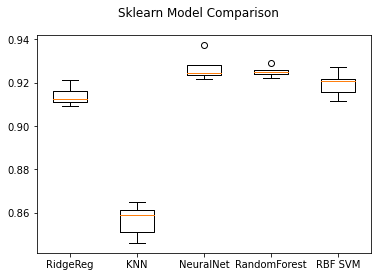

In [17]:
classifier_comparison(X3, y3, 42)

# Running the Analysis for Other Organisms

In [22]:
# Running the model comparison on yeast data set WITH signal peptides
yeast_X = np.stack(yeast_unirep_withSP["UniRep"].to_numpy())
yeast_y = np.array(yeast_unirep_withSP['location'])
yeast_X_train, yeast_X_test, yeast_y_train, yeast_y_test = train_test_split(yeast_X, yeast_y, test_size=0.2, random_state=42)

RidgeReg: 0.962099 (0.003963)
KNN: 0.938232 (0.007122)
NeuralNet: 0.965193 (0.004516)
RandomForest: 0.964309 (0.005748)
RBF SVM: 0.961768 (0.006303)


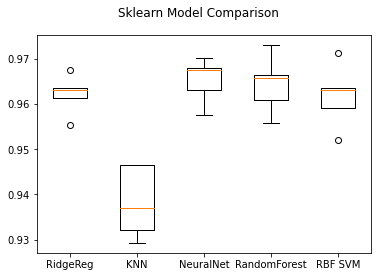

In [23]:
classifier_comparison(yeast_X, yeast_y, 42)

In [26]:
# Running the model comparison on yeast data set WITHOUT signal peptides
yeast_X2 = np.stack(yeast_unirep_noSP["UniRep"].to_numpy())
yeast_y2 = np.array(yeast_unirep_noSP['location'])
yeast_X2_train, yeast_X2_test, yeast_y2_train, yeast_y2_test = train_test_split(yeast_X2, yeast_y2, test_size=0.2, random_state=42)

RidgeReg: 0.843752 (0.010486)
KNN: 0.783144 (0.005445)
NeuralNet: 0.844967 (0.005678)
RandomForest: 0.832567 (0.005404)
RBF SVM: 0.856412 (0.007732)


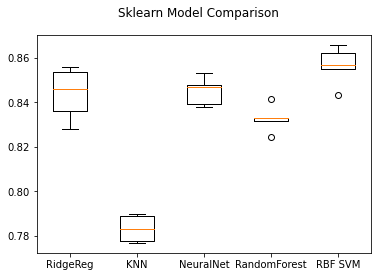

In [27]:
classifier_comparison(yeast_X2, yeast_y2, 42)

In [28]:
# Add additional features
yeast_add_withSP = use_additional_features(yeast_unirep_withSP)
yeast_add_noSP = use_additional_features(yeast_unirep_noSP)

In [32]:
# Running model comparison on addiitonal yeast data WITHOUT signal peptides

In [30]:
# Running the model comparison on E. Coli data set WITHOUT signal peptides
ecoli_X = np.stack(ecoli_unirep_noSP["UniRep"].to_numpy())
ecoli_y = np.array(ecoli_unirep_noSP['location'])

RidgeReg: 0.986913 (0.003226)
KNN: 0.929123 (0.003551)
NeuralNet: 0.988377 (0.001794)
RandomForest: 0.987970 (0.001919)
RBF SVM: 0.984475 (0.002263)


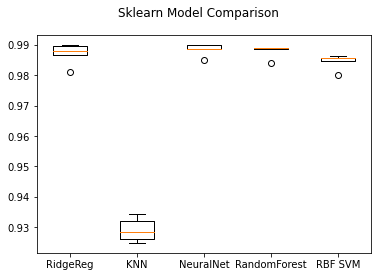

In [31]:
classifier_comparison(ecoli_X, ecoli_y, 42)